# Resnet Autoencoder

This notebook trains the resnet autoencoder and then clusters the encoded data.

## Imports

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 37.6MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np
from automatic_asset_classification import pretrainedModel

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"
#%cp "/content/drive/My Drive/automatic-asset-classification/data/final_dataset" .
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_3_torch  ae_res_5_torch       final_model  res_model1.pt
ae_res_1_torch  ae_res_4_new    ae_res_6_new         model1.pt    res_model2.pt
ae_res_2_new    ae_res_4-new    ae_res_6_torch       model2.pt    test.png
ae_res_2_torch  ae_res_4_torch  basic_animation.mp4  models/
ae_res_3_new    ae_res_5_new    data/                outputs/


## Import the data

In [4]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))
print("imported")

imported


## Training

### Initiate Model

In [0]:
ae = pretrainedModel.autoencoder()

In [0]:
learn = Learner(data, ae, loss_func=F.mse_loss)

### Training

In [10]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.218726,0.193823,02:17
1,0.183358,0.177155,00:30
2,0.161630,0.139312,00:27
3,0.146469,0.111922,00:27
4,0.133611,0.097583,00:26
5,0.122179,0.089380,00:26
6,0.113592,0.084864,00:26
7,0.106767,0.081853,00:27
8,0.101076,0.080211,00:26
9,0.096986,0.079878,00:26


In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.084058,#na#,00:20
1,0.084699,#na#,00:19
2,0.084366,#na#,00:19
3,0.083687,#na#,00:19
4,0.082379,#na#,00:19
5,0.081055,#na#,00:19
6,0.082024,#na#,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.20E-02


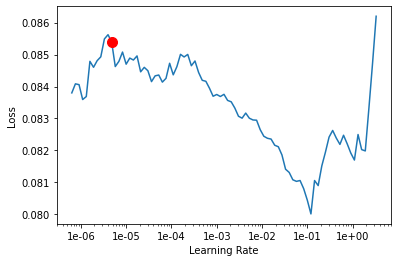

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
learn.split(lambda m: (m.encoder.encoder[0][1], m.encoder.encoder[0][2], m.encoder.encoder[0][3], 
                       m.encoder.encoder[0][4], m.encoder.encoder[0][5], m.encoder.encoder[0][6], 
                       m.encoder.encoder[0][7], m.encoder.encoder[1], m.decoder))
print("model split")

model split


Include early stopping.

In [0]:
learn.callback_fns.append(partial(EarlyStoppingCallback, mode='min', min_delta=0.005, patience=3))

In [15]:
learn.unfreeze()
learn.fit_one_cycle(25, max_lr=slice(1e-05, 1e-02))

epoch,train_loss,valid_loss,time
0,0.081599,0.072556,00:28
1,0.077560,0.070536,00:28
2,0.072633,0.071532,00:27
3,0.067348,0.073472,00:27
4,0.061897,0.054188,00:28
5,0.056794,0.063869,00:27
6,0.052307,0.049012,00:27
7,0.048183,0.056217,00:28
8,0.045003,0.042196,00:28
9,0.041819,0.032789,00:29


Epoch 16: early stopping


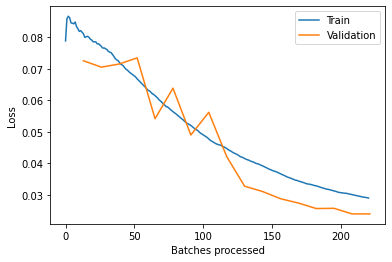

In [16]:
learn.recorder.plot_losses()

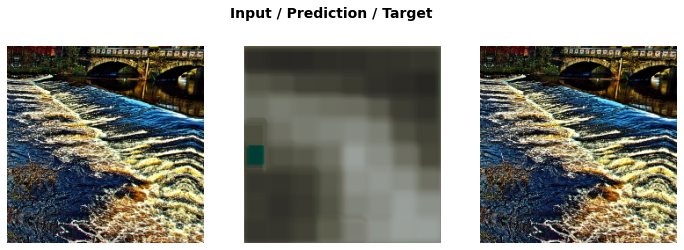

In [17]:
learn.show_results(ds_type=DatasetType.Train, rows=1)

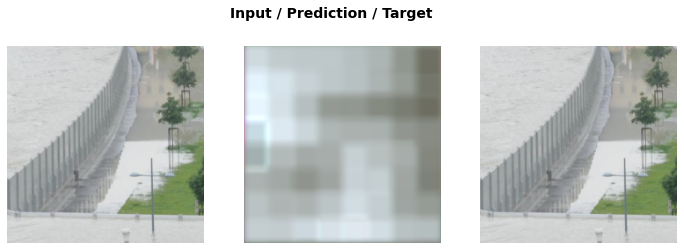

In [19]:
learn.show_results(ds_type=DatasetType.Valid, rows=1)

### Save the model for later use

In [20]:
torch.save(learn.model, "resnet_autoencoder_model.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6

## Clustering

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.load("resnet_autoencoder_model.pt").encoder
        
    def encode(self,x): return self.encoder(x)
        
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [0]:
ec = Encoder()
enc=Learner(data, ec,loss_func=F.mse_loss)

In [24]:
preds,acts=enc.get_preds()

In [0]:
cluster_data = preds.numpy()

In [0]:
cluster_data_std = (cluster_data - cluster_data.mean())/cluster_data.std()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cluster_data_pca = pca.fit_transform(cluster_data_std)

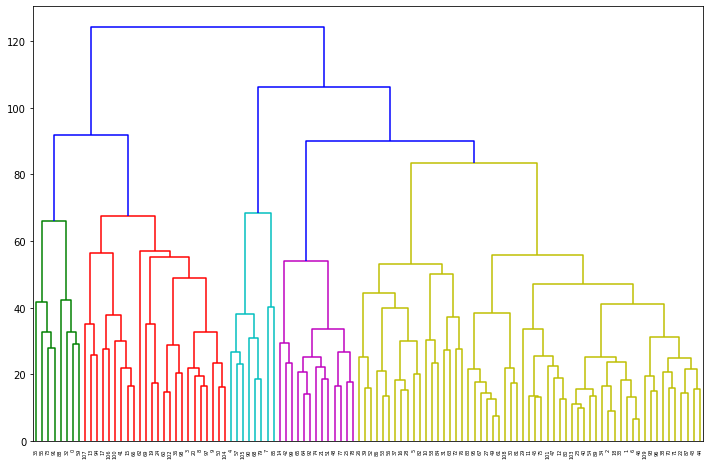

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(cluster_data_pca, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

5 clusters splits the data.

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca)
X_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca)
X_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca)

In [0]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(cluster_data_pca)

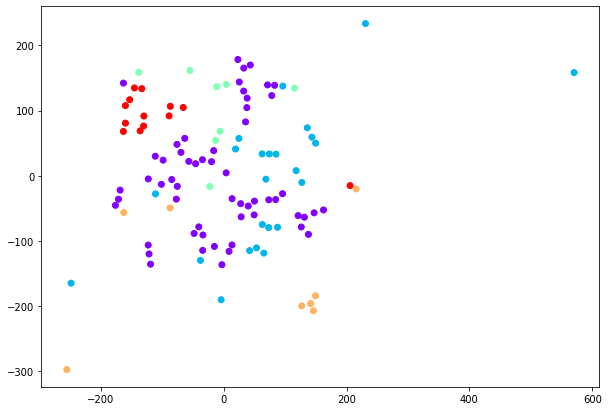

In [33]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_, cmap='rainbow')

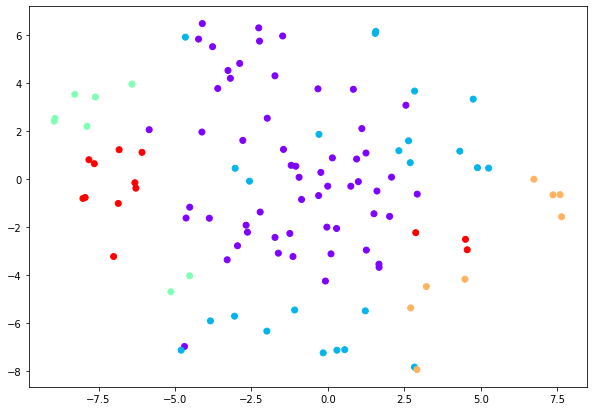

In [35]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

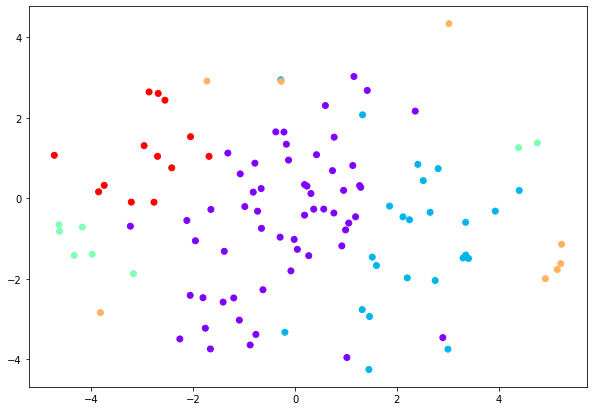

In [36]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

In [0]:
one_idx = []
two_idx = []
three_idx=[]
four_idx=[]
five_idx=[]

for i in range(len(clusters)):
    if clusters[i] == 0:
        one_idx.append(i)
    if clusters[i] == 1:
        two_idx.append(i)
    if clusters[i] == 2:
        three_idx.append(i)
    if clusters[i] == 3:
        four_idx.append(i)
    if clusters[i] == 4:
        five_idx.append(i)

In [0]:
for idx in one_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder"
                               "/class1/"+str(idx)+".png")
for idx in two_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder"
                               "/class2/"+str(idx)+".png")
for idx in three_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder"
                               "/class3/"+str(idx)+".png")
for idx in four_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder"
                               "/class4/"+str(idx)+".png")
for idx in five_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder"
                               "/class5/"+str(idx)+".png")